## LETS WORK TOWARD ITERROWS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
%load_ext line_profiler
from tqdm import tqdm

windows = True # If on mac put false, windows true

#### data input

In [2]:
if windows == True:
    baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines\baselines_met.csv", index_col=0) # FOR WINDOWS
    
    pickle_in = open(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines\baselines_pt_averaged.pickle",'rb')
    baseline_pt_averaged = pickle.load(pickle_in)
else:
    baselines = pd.read_csv(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines/baselines_met.csv", index_col=0) # FOR MAC
    
    pickle_in = open(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines/baselines_pt_averaged.pickle",'rb')
    baseline_pt_averaged = pickle.load(pickle_in)

#### paramaters

In [19]:
#outside params, _o stands for original
H = 0.42 #no units,ratio #Hematocrit assumed to be constant
# M_o = 30* 10e-9 #mol_ O2/(mL/s) #Taken from table 2 from Wiley Payne paper
cHb = 0.2 #mL_O2/mL #Taken from table 2 from Wiley Payne paper
paO2_bar_t = 15 #mmHG #Taken from table 2 from Wiley Payne paper
K_o = 5e-8 #µL/(mm*s*mmHg) #payne paper and boas et al
alpha_t = 2.6e-5 #mL_O2/(mL*mmHg) from payne paper, solutbility coeff of oxygen in brain tissue

#convert param to my SU
M_constant = 8.20e-4 # cm3_O2/(cm3*s) , still unsure about the exact conversion so will just input in this section
K = K_o * (1e6) # µm2/(s*mmHg)

#model input params
delay_pressure_drop = 4
time_for_drop = 1
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
n=1
ratio_drop = 0.5
hill_constant = 2 # mmHg
# kp_constant = 1/300 # s-1
kp_constant = 1/300 # s-1
kn_constant = 1/600 # s-1

#loop info
# no = 1000001 #12501
# max_time = 400
no = 400001 #12501
max_time = 300

#### work out vectors

In [20]:
t = pd.Series(np.linspace(0,max_time,no))
dt = max_time/(no-1)
drop_value = 60 - 34.18*ratio_drop

#### PRessure stuff
pressure_in = pd.Series(np.zeros(len(t)))
for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    elif t[i] <= delay_pressure_drop + time_for_drop:
        pressure_in[i] = 60 - ((t[i] - delay_pressure_drop)/time_for_drop)*(60-drop_value)
    else:
        pressure_in[i] = drop_value
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out

print('Time of simulation :',max_time,'seconds')
print('Time vessels :',dt,'seconds')
print('Number of iterations:',no)

Time of simulation : 300 seconds
Time vessels : 0.00075 seconds
Number of iterations: 400001


## Model

#### Functions

In [21]:
def total_R(baselines,phi,alpha):
    """Calculates the resistance of the network.
    
    """
    
    C_ = alpha*(baselines.at[6,'Resistance for Q']/2)/phi**4  + (1-alpha)*(baselines.at[6,'Resistance for Q']/2)
    C_6 = (C_ + baselines.at[5,'Resistance for Q'] + baselines.at[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.at[4,'Resistance for Q'] + baselines.at[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.at[3,'Resistance for Q'] + baselines.at[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.at[2,'Resistance for Q'] + baselines.at[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.at[1,'Resistance for Q'] + baselines.at[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.at[0,'Resistance for Q'] + baselines.at[12,'Resistance for Q']
    R_total = C_654321
    return R_total
 
def check_imag_roots_real(two_roots):
    """Takes two imaginary roots from the Servinghaus equation and returns the real one.
    
    Will print if there is an error.
    Returns real root."""
    
    counter = 0
    sols = 0
    for i in range(len(two_roots)):
        if two_roots[i].imag <= 10e-13 and two_roots[i].imag >= -10e-13:
            sols = two_roots[i].real
            counter += 1
    if counter != 1:
        print('Something seems wrong with the partial presure to Saturation cubic solver as not one solution is returned.')
    return sols

def master(alpha,delay,baselines):
    """Entire model.
    
    """  
    ###Set up
    
    delay_number = round(delay/dt) #finds nearest index to the 
    
    network = pd.DataFrame()
    network['t'] = t
    network['pressure_difference'] = pressure_difference
    network['phi'] = pd.Series(np.zeros(no))
    network['phi_min'] = pd.Series(np.zeros(no))
    network['dphidt'] = pd.Series(np.zeros(no))
    network['R_tot'] = pd.Series(np.zeros(no))
    network['Q_tot'] = pd.Series(np.zeros(no))
    network['Q_norm'] = pd.Series(np.zeros(no))
    network['pt_averaged'] = pd.Series(np.zeros(no))
    
    network['pt_averaged_50'] = pd.Series(np.zeros(no))
    network['pt_averaged_5'] = pd.Series(np.zeros(no))
    network['kp_p'] = pd.Series(np.zeros(no))
    network['kp_n'] = pd.Series(np.zeros(no))
    network['dApdt'] = pd.Series(np.zeros(no))
    network['Ap'] = pd.Series(np.zeros(no))
    network['dDpdt'] = pd.Series(np.zeros(no))
    network['Dp'] = pd.Series(np.zeros(no))
    
    ### Initialise values
    
    network.at[0,'phi'] = 1
    network.at[0,'phi_min'] = 1
    network.at[0,'dphidt'] = 0
    network.at[0,'Ap'] = 1
    network.at[0,'Dp'] = 0
    network.at[0,'pt_averaged'] = baseline_pt_averaged # kind of a bit of a different way to the rest. So I can embed the new parts where they should be in for loop.
    
    pt_averaged_50 = baseline_pt_averaged*0.8
    pt_averaged_5 = baseline_pt_averaged*0.1
    
    R = 1
    k = 0.1
    tau_c = 1/600 #s-1
    c_baseline = R/(1+k)
    network.at[0,'c'] = c_baseline
    c_50 = c_baseline*10
    c_5 = c_baseline
    network.at[0,'An'] = 1
    network.at[0,'Dn'] = 0
    
    
    for i in tqdm(range(len(t))):
        """For each time step:
        
        """  
        ### Update network paramaters
        
        network.at[i,'R_tot'] = total_R(baselines,network.at[i,'phi'],alpha)
        network.at[i,'Q_tot'] = network.at[i,'pressure_difference']/network.at[i,'R_tot']
        network.at[i,'Q_norm'] = network.at[i,'Q_tot'] / baselines['Q in single(µm3/s)'][0]
        
        #New bits:
        network.at[i,'kp_p'] = (kp_constant/2)*(1-np.tanh( (network.at[i,'pt_averaged']-pt_averaged_50) / pt_averaged_5))
        network.at[i,'kp_n'] = (kp_constant/2)*(1+np.tanh( (network.at[i,'pt_averaged']-pt_averaged_50) / pt_averaged_5 ))
        network.at[i,'dApdt'] = -network.at[i,'kp_p']*network.at[i,'Ap'] + network.at[i,'kp_n']*(1-network.at[i,'Ap']-network.at[i,'Dp'])
        network.at[i,'dDpdt'] = network.at[i,'kp_p']*(1-network.at[i,'Ap']-network.at[i,'Dp'])
        
        network.at[i,'kn_p'] = (kn_constant/2)*(1+np.tanh( (network.at[i,'c']-c_50) / c_5))
        network.at[i,'kn_n'] = (kn_constant/2)*(1-np.tanh( (network.at[i,'c']-c_50) / c_5 ))
        network.at[i,'dAndt'] = -network.at[i,'kn_p']*network.at[i,'An'] + network.at[i,'kn_n']*(1-network.at[i,'An']-network.at[i,'Dn'])
        network.at[i,'dDndt'] = network.at[i,'kn_p']*(1-network.at[i,'An']-network.at[i,'Dn'])
        
        network.at[i,'dcdt'] = (1/tau_c)*(R-network.at[i,'c']*(k+network.at[i,'Q_norm']))
 

        if i-delay_number <0: # As cant index before 0 as not initialised for that.
            network.at[i,'dphidt'] =  (1/optimised_value_tau)*( - 1 + network.at[i,'Q_norm']*(1-network.at[i,'phi_min']) + network.at[i,'phi_min'] )
        else:
            network.at[i,'dphidt'] =  (1/optimised_value_tau)*( -network.at[i-delay_number,'phi'] + network.at[i,'Ap']*(network.at[i,'Q_norm']*(1-network.at[i,'phi_min']) + network.at[i,'phi_min']) )
            
        #Euler    
        network.at[i+1,'phi'] = network.at[i,'dphidt']*dt + network.at[i,'phi']
        network.at[i+1,'phi_min'] = 1-(alpha**0.25)*(1-phi_min_baseline)*(1-network.at[i,'Q_norm'])**n  
        
        network.at[i+1,'Ap'] = network.at[i,'dApdt']*dt + network.at[i,'Ap']   
        network.at[i+1,'Dp'] = network.at[i,'dDpdt']*dt + network.at[i,'Dp']  
        
        network.at[i+1,'An'] = network.at[i,'dAndt']*dt + network.at[i,'An']   
        network.at[i+1,'Dn'] = network.at[i,'dDndt']*dt + network.at[i,'Dn']  
        network.at[i+1,'c'] = network.at[i,'dcdt']*dt + network.at[i,'c']  
        #### Update Vessel paramaters
        
        # Euler from previous model. Necessary for: ...
        if i == 0:                                  
            vessels = first_iteration.copy()
        else:
            vessels = vessel_data_alltime[i-1].copy()
            #Following works as I have loaded in previous values. Then updateding for the new ones Forwards Euler.
            vessels['tissue partials(mmHg)'] = vessels['tissue partials(mmHg)'] + vessels['dptdt']*dt
            vessels['Saturation out'] = vessels['Saturation out'] + vessels['dSoutdt']*dt
            vessels['Saturation in'] = vessels['Saturation in'] + vessels['dSindt']*dt 
        #Update other values for new flow
        vessels.at[6,'Diameter(µm)'] = baseline.at[6,'Diameter(µm)']*network.at[i,'phi']    
        vessels.at[6,'X-Area wall(???)'] = np.pi * ( 0.16*(vessels.at[6,'Diameter(µm)'])**2 + 1.4*(vessels.at[6,'Diameter(µm)']) + 14 )
        vessels.at[6,'wall thickness(µm)'] = ( -(vessels.at[6,'Diameter(µm)']) + np.sqrt((vessels.at[6,'Diameter(µm)'])**2 + (4*(vessels.at[6,'X-Area wall(???)'])/np.pi))) / 2
        vessels['Saturation ave'] = (vessels['Saturation in']+vessels['Saturation out'])/2
        vessels['M'] = (network.at[i,'An'])*M_constant*vessels['tissue partials(mmHg)']/(vessels['tissue partials(mmHg)']+hill_constant)
        for j in range(len(vessels['Saturation ave'])):
            root_temp = None
            sols = 0
            root_temp = np.roots([1,0,150,23400*vessels.at[j,'Saturation ave']/(vessels.at[j,'Saturation ave']-1)]) #gives mmHg
            sols = check_imag_roots_real(root_temp) 
            vessels.at[j,'partial pressure blood(mmHg)'] = sols    
        #Could just do the flow update as ratio of previous flow to new flow then times previous values by this ratio as all flows scale linearly.
        for j in range(len(vessels)):
            """For each vessel
            Update Q in single based on updated Q_tot
            Calculate dSoutdt and make this dSindt for next vessel."""
            #Could definitely get rid of this by not updating. I ahve all the values I realistically need with one column. Just for completeness. Could just have dSoutdt for each vessel and know this is thenext ones dSinDt. and know for A1 is is 0.
            if j ==0:
                vessels.at[j,'dSindt'] = 0
                vessels.at[j,'Q in single(µm3/s)'] = network.at[i,'Q_tot']
            else:
                vessels.at[j,'dSindt'] = vessels.at[j-1,'dSoutdt']
                if j <=  6:
                    vessels.at[j,'Q in single(µm3/s)'] = vessels.at[j-1,'Q in single(µm3/s)']/2
                else:
                    vessels.at[j,'Q in single(µm3/s)'] = vessels.at[j-1,'Q in single(µm3/s)']*2

            vessels.at[j,'dSoutdt'] = 2/(np.pi*((vessels.at[j,'Diameter(µm)']**2)/4)*vessels.at[j,'Length(µm)']) \
                                    * ( - (2 * np.pi * K * (vessels.at[j,'Diameter(µm)']/2) * constant.at[j,'Length(µm)'])/(vessels.at[j,'wall thickness(µm)']*cHb*H) \
                                    * (vessels.at[j,'partial pressure blood(mmHg)']-vessels.at[j,'tissue partials(mmHg)'])\
                                    - vessels.at[j,'Q in single(µm3/s)']*(vessels.at[j,'Saturation out']-vessels.at[j,'Saturation in']) )\
                                    - vessels.at[j,'dSindt']
            
        ### The main show: calculating dpdt and other useful representations.
        
        vessels['dptdt'] = (1/(alpha_t*constant['Vt(µm3)']))\
                        *(((2 * np.pi * K * (vessels['Diameter(µm)']/2) * constant['Length(µm)'])/(vessels['wall thickness(µm)']))\
                        *(vessels['partial pressure blood(mmHg)']-vessels['tissue partials(mmHg)'])\
                        - vessels['M'] * constant['Vt(µm3)'])
        vessels['pt_by_Vt'] = vessels['tissue partials(mmHg)'] * vessels['Vt(µm3)']

        network.at[i+1,'pt_averaged'] = vessels['pt_by_Vt'].sum()/13 ###### BADDDDDDd

        ### Save vessels to a dictionary
        
        vessel_data_alltime[i] = vessels
    
    ### To let you know whether it managed to run all the way through.
    
    if i == no-1:
        print('finished')
    else:
        print('broken')
    
    return network, vessel_data_alltime

#### Clean up baselines

#### the loop

100%|██████████| 400001/400001 [53:23<00:00, 124.87it/s] 


finished
min: 1.4070181074364e-25
final: 0.004980989134884685


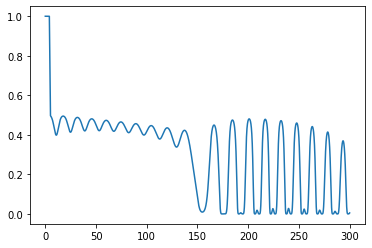

In [22]:
# Initialise Data, set up DFs
baseline = baselines.drop(['Viscocity(mmHg*s)','Resistance for U', 'U in single(µm/s)'],axis=1)
first_iteration = baseline.loc[:,['Name','Number','Diameter(µm)','Length(µm)','Saturation in','Saturation out','Resistance for Q','Q in single(µm3/s)','Vt(µm3)','partial pressure blood(mmHg)','X-Area wall(???)','wall thickness(µm)','tissue partials(mmHg)']].assign(dptdt = np.zeros(len(baseline)))
constant = baseline.drop(['Q in single(µm3/s)','Pressure Drop(mmHg)','Saturation in','Saturation out','Resistance for Q','dS','Saturation ave','partial pressure blood(mmHg)','X-Area wall(???)','wall thickness(µm)','tissue partials(mmHg)'], axis=1)
vessel_data_alltime = {}
pt_averaged = pd.Series(np.zeros(len(t)))
terms_data_alltime = {}

alpha = 0.5
delay = 2.99

# %timeit euler2(alpha,delay,baselines)

# %timeit -r 10 -n 1 run()
        
# %prun -s cumulative run()

# %lprun -f master master(alpha,delay,baselines)

N,V_alltime = master(alpha,delay,baselines)
plt.plot(N['t'],N['Q_norm'])
print('min:',min(N['Q_norm']))
print('final:', N.at[len(N)-2,'Q_norm'])

In [1]:
# plt.plot(N['t'],N['pt_averaged'])
# plt.plot(N['t'],N['pt_averaged']/N.at[0,'pt_averaged'])
# min(N['pt_averaged']/N.at[0,'pt_averaged'])
plt.plot(N['t'],N['Ap'])
plt.plot(N['t'],N['Dp'])
plt.plot(N['t'],N['An'])
plt.plot(N['t'],N['Dn'])

NameError: name 'plt' is not defined

In [ ]:
N

In [ ]:
def plot_param(column_name,normal = 0):
    df = None
    string = None
    df = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
    for i in range(len(vessel_data_alltime)):
        for j in range(len(vessel_data_alltime[0])):
            df.iloc[i,j] = vessel_data_alltime[i].at[j,column_name]
    fig,ax = plt.subplots(figsize=(10,8))
    if normal == 1:
        df_normal =  pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
                       'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
        for i in range(len(vessel_data_alltime[0])):
            df_normal.iloc[:,i] = df.iloc[:,i] / baseline.at[i,column_name]
        column_name = column_name + 'normal'
        scale = df_normal.iloc[0,0] / pressure_difference[0]
        plt.plot(t,scale*(pressure_difference),label='pressure in', color='0.8')
        plt.ylim(0,1.1)
    for i in range(13):
        if normal ==0:
            plt.plot(t,df.iloc[:,i], label=vessel_data_alltime[0].at[i,'Name'])
        elif normal ==1:
            plt.plot(t,df_normal.iloc[:,i], label=vessel_data_alltime[0].at[i,'Name'])
        else:
            print('error')
    ax.legend()
    plt.grid(which='both')
    string = column_name + ' against time'
    plt.ylabel(column_name)
    plt.xlabel('time /s')
    plt.title(string, fontsize=20)
    
# plot_param('partial pressure blood(mmHg)')
plot_param('partial pressure blood(mmHg)',1)
# plot_param('tissue partials(mmHg)')
plot_param('tissue partials(mmHg)',1)
plot_param('Saturation in')
plot_param('Saturation out')
# plot_param('pt_averaged')
# plot_param('Q in single(µm3/s)')
plot_param('Q in single(µm3/s)',1)
# plot_param('dptdt')
# plot_param('dSoutdt')
# plot_param('dSindt')

In [ ]:
save = False
if save == True:
    if windows == True:
        pickle_out = open(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\out_pressures_new.pickle",'wb')
        pickle.dump(vessel_data_alltime, pickle_out)
        pickle_out.close()
        
        pickle_out2 = open(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\terms_new.pickle",'wb')
        pickle.dump(terms_alltime, pickle_out2)
        pickle_out2.close()
    else:
        pickle_out = open(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/out_pressures_new_2_99.pickle",'wb')
        pickle.dump(vessel_data_alltime, pickle_out)
        pickle_out.close()
        
        pickle_out2 = open(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/terms_new_2_99.pickle",'wb')
        pickle.dump(terms_alltime, pickle_out2)
        pickle_out2.close()
#### CHANGE TO BASELINES WITHIN FOLDER. this means i dont need to worry about changing baselines for later calcls unless i absolutely want to

In [26]:
min(N['Q_norm'])

0.40146469786344946

In [59]:
print('final:', N.at[len(N)-2,'Q_norm'])

final: 0.4740659919836162
